In [1]:
import os
import cv2
import json
import numpy as np
import pickle
import csv
import re
import pandas as pd
import matplotlib.patches as patches
import torch as T

from matplotlib import pyplot as plt
from time import sleep

%matplotlib inline

---

# WIDER Face

In [6]:
from data.datasets import WIDERFaceDataset

number_of_faces = 10
image_shape = (448, 896)
wider_face_dataset = WIDERFaceDataset(image_shape=image_shape, max_number_of_faces=number_of_faces)

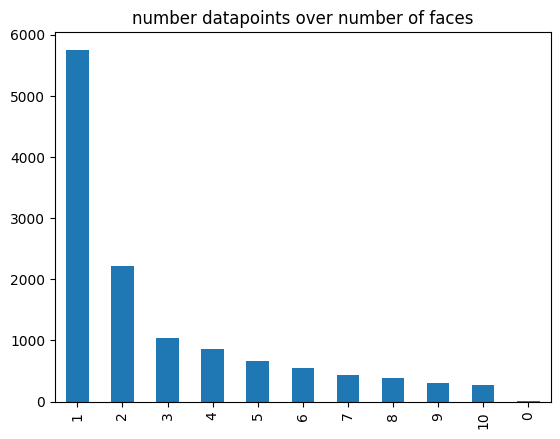

In [7]:
face_counts = pd.Series([anot_dp["number_of_faces"] for anot_dp in wider_face_dataset.annotation_datapoints]).value_counts()
face_counts[:20].plot.bar()
plt.title("number datapoints over number of faces")
plt.show()

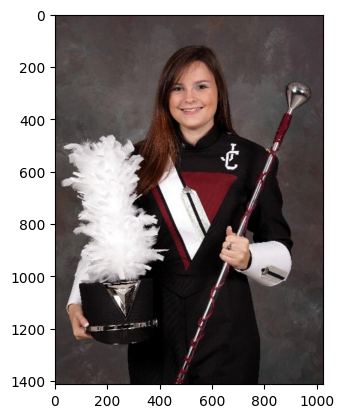

In [8]:
test_i = 11

original_image = cv2.cvtColor(cv2.imread(wider_face_dataset.annotation_datapoints[test_i]["image_path"]), cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.show()

number of faces 1


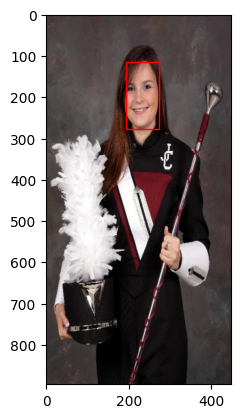

In [9]:

print(f"number of faces {wider_face_dataset.annotation_datapoints[test_i]['number_of_faces']}")

test_image = wider_face_dataset[test_i]["image"].permute(1, 2, 0).round().byte().numpy()
faces = wider_face_dataset[test_i]["face_bbox"]

_, ax = plt.subplots()

ax.imshow(test_image)

for i in range(0, len(faces), 4):
    x, y, w, h = faces[i:i+4]
    rect = patches.Rectangle((x-w, y-h), w*2, h*2, linewidth=1, edgecolor="red", facecolor="none")
    ax.add_patch(rect)

plt.show()

---

# WFLW

In [2]:
from data.datasets import WFLWDataset

wflw_dataset = WFLWDataset((448, 224), 10)


tensor([265.5781, 136.7276])


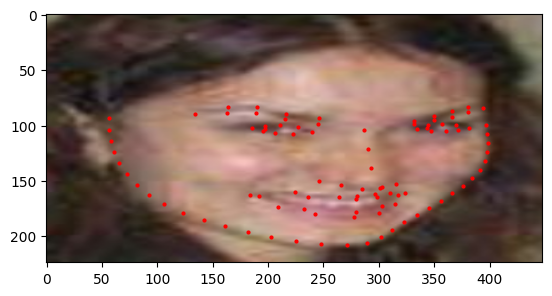

In [3]:
test_i = 4

test_image = wflw_dataset[test_i]["image"].permute(1, 2, 0).round().byte().numpy()

_, ax = plt.subplots()

ax.imshow(test_image)

for dp in wflw_dataset[test_i]["keypoints"]:
    ax.plot(dp[0], dp[1], "ro", markersize=2)

print(wflw_dataset[test_i]["keypoints"].mean(0))

plt.show()

# COFW

In [2]:
from data.datasets import COFWColorDataset

cofw_color_dataset = COFWColorDataset((448, 224))

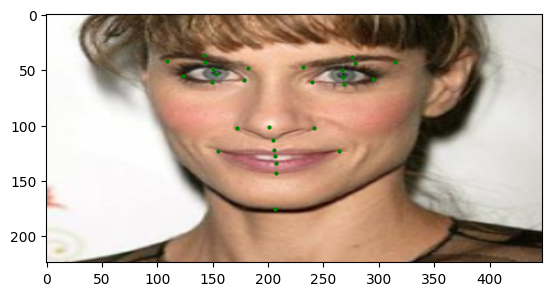

In [4]:
test_i = 1

test_image = cofw_color_dataset[test_i]["image"].permute(1, 2, 0).round().byte().numpy()

_, ax = plt.subplots()

ax.imshow(test_image)

kpts = cofw_color_dataset[test_i]["keypoints"]
for i in range(kpts.shape[0]):
    if cofw_color_dataset[test_i]["occlusion"][i] == 1:
        ax.plot(kpts[i][0], kpts[i][1], "ro", markersize=2)
    else:
        ax.plot(kpts[i][0], kpts[i][1], "go", markersize=2)

plt.show()

# hico_det

In [ ]:
# hd = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno.mat")
# hd_bb = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno_bbox.mat")

# """

# len(hd_bb["bbox_train"][0][i][1][0]) = 1

# len(hd_bb["bbox_train"][0][i][0]) = 1
# (name)


# """

In [ ]:
# hd_bb.keys()

In [ ]:
# print(len(hd["list_train"]), len(hd["list_test"]))

# hd_bb["bbox_train"][0][0][0]
# hd_bb["bbox_train"][0][0][1]

# for i in range(len(hd_bb["bbox_train"][0])):
#     image_name = hd_bb["bbox_train"][0][i][0][0]

#     width, height, depth = hd_bb["bbox_train"][0][i][1][0][0]
#     width, height, depth = width[0][0], height[0][0], depth[0][0]


# sum([len(hd_bb["bbox_train"][0][i][2][0]) for i in range(len(hd_bb["bbox_train"][0]))])

# [b[1] for b in hd_bb["bbox_train"][0][0][2][0]]




# RHDv2

In [ ]:
# arr = pickle.load(open("./../_data/_usefull/_images/RHD_published_v2/training/anno_training.pickle", "br"))

"""

arr[i]["xyz"] = xyz keypoints
arr[i]["uv_vis] = uv + visibility
arr[i]["K"] = camera
(i == image)


"""
None

# HAKE

In [ ]:
# hake_large_annotation = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hake_large_annotation.json", "r"))
# hico_det_training_set_instance_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-det-training-set-instance-level.json", "r"))
# hico_training_set_image_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-training-set-image-level.json", "r"))

"""

hico training set image level

{'arm_list': [0, 0, 0, 0, 1], 
'foot_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'hand_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'head_list': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
'hip_list': [1, 0, 0, 0, 0], 
'hoi_id': [153, 154, 155, 156], 
'leg_list': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
'parts_list': [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]}


hico det training set instance level

{'dataset': 'hico-det', 
'labels': [
    {
        'action_labels': 
            [{'human_part': 6, 'partstate': 0}, 
            {'human_part': 9, 'partstate': 0}, 
            {'human_part': 4, 'partstate': 0}, 
            {'human_part': 0, 'partstate': 0}, 
            {'human_part': 3, 'partstate': 0}], 
        'height': 480, 
        'hoi_id': 153, 
        'human_bbox': [208, 33, 427, 300], 
        'object_bbox': [59, 98, 572, 405], 
        'width': 640
    }, 
    {
        'action_labels': 
            [{'human_part': 4, 'partstate': 0}, 
            {'human_part': 1, 'partstate': 6}, 
            {'human_part': 2, 'partstate': 6}], 
        'height': 480, 
        'hoi_id': 156, 
        'human_bbox': [209, 26, 444, 317], 
        'object_bbox': [59, 99, 579, 395], 
        'width': 640
    },
        ...], 
'path_prefix': 'hico_20160224_det/images/train2015'}



hake large annotation

{'dataset': 'hico-det', 
'labels': [
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 153, 'human_bbox': [208, 33, 427, 300], 'object_bbox': [59, 98, 572, 405], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 4, 'partstate': 0}, {'human_part': 1, 'partstate': 6}, {'human_part': 2, 'partstate': 6}], 'height': 480, 'hoi_id': 156, 'human_bbox': [209, 26, 444, 317], 'object_bbox': [59, 99, 579, 395], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 154, 'human_bbox': [213, 20, 438, 357], 'object_bbox': [77, 115, 583, 396], 'width': 640}, {'action_labels': [{'human_part': 4, 'partstate': 0}], 'height': 480, 'hoi_id': 155, 'human_bbox': [206, 33, 427, 306], 'object_bbox': [61, 100, 571, 401], 'width': 640}], 
    ...
    
'path_prefix': 'hico_20160224_det/images/train2015'}


"""
None

# FreiHAND

In [ ]:
"""
training_K = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_K.json", "r"))
training_mano = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_mano.json", "r"))
training_scale = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_scale.json", "r"))
training_verts = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_verts.json", "r"))
training_xyz = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_xyz.json", "r"))

# length is the same for all = 32560 = number of greenscreened images

K = intrinsic camera matrix
mano = mano annotations ?
verts = 3d vertecies
xyz = 3d shape
"""
None4

# Kinect

In [ ]:
# info = json.load(open("./../_data/_usefull/KinectDatasets/data/training/info.json", "r"))
# calib = json.load(open("./../_data/_usefull/KinectDatasets/data/training/calib.json", "r"))
# anno = json.load(open("./../_data/_usefull/KinectDatasets/data/training/anno.json", "r"))
# pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/training/pred_sdk.json", "r"))

# captury_info = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/info.json", "r"))
# captury_calib = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/calib.json", "r"))
# captury_anno = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/anno.json", "r"))
# captury_pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk.json", "r"))
# captury_pred_sdk_cap = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk_cap.json", "r"))

"""
1920x1080

anno[0][0] = 18 kpts + vis

pred_sdk[0][i] = 25 kpts + vis (is a prediction)
(i == 4 for all)


captury_pred_sdk[0][i] = 25 kpts + vis
(i == 1 for all)

captury_pred_sdk_cap[0][i] = 25 kpts + vis
(i == 2 for all)


"""
None